In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

In [28]:
ventas = pd.read_csv('ventas.csv')
productos = pd.read_csv('20230223_productos.csv')
clientes = pd.read_csv('customers_sampled.csv')

# Convertir 'calmonth' a formato de fecha
ventas['date'] = pd.to_datetime(ventas['calmonth'], format='%Y%m')
# date como índice
ventas.set_index('date', inplace=True)
ventas.drop(columns='calmonth', inplace=True)

In [29]:
# Find the first sale date for each product
df_reset = ventas.reset_index()
first_sale = df_reset.groupby('material')['date'].min().reset_index()
first_sale = first_sale.rename(columns={'date': 'first_sale_date'})
# Merge first sale dates back to the original DataFrame
df_merged = df_reset.merge(first_sale, on='material', how='left')

In [30]:
ventas = ventas.rename(columns={'material': 'Material'})
ventas_productos = pd.merge(ventas, productos, on='Material')

In [31]:
ventas_productos = ventas_productos.drop(columns=['Productos_Por_Empaque', 'BrandPresRet', 'Presentation', 'SegAg', 'SegDet', 'GlobalSubcategory', 'BrandGrouper', 'Returnability', 'Pack', 'Flavor', 'Container', 'Ncb', 'MLSize'])

In [32]:
ventas_productos.head(2)

,CustomerId,Material,uni_box,Material_desc,ProdKey,Brand,Size,ProductType,ProductCategory,GlobalCategory,GlobalFlavor
0,499920078,9151,0.4364,DEL VALLE GUAYABA NECTAR 413 ML NR VD 6B,JUGOS Y NECTARES IMPULSO,DEL VALLE,INDIVIDUAL,JUGOS Y NECTARES,CATEGORIAS EN EXPANSION,BEBIDAS EMERGENTES,GUAYABA
1,499920078,9151,0.4364,DEL VALLE GUAYABA NECTAR 413 ML NR VD 6B,JUGOS Y NECTARES IMPULSO,DEL VALLE,INDIVIDUAL,JUGOS Y NECTARES,CATEGORIAS EN EXPANSION,BEBIDAS EMERGENTES,GUAYABA


In [33]:
ventas_totales_productos = ventas_productos.groupby('ProductType')['uni_box'].sum()
compras_totales_por_customerid = ventas_productos.groupby("CustomerId")['uni_box'].sum()
ventas_productos["Compras totales del cliente por producto"] = ventas_productos.groupby(["CustomerId", "ProductType"])["uni_box"].transform('sum')
ventas_productos["Ventas totales del producto"] = ventas_productos["ProductType"].map(ventas_totales_productos)
ventas_productos["Percentage of product type sales of the total sales"] = (ventas_productos["Compras totales del cliente por producto"] / ventas_productos["Ventas totales del producto"]) * 100

In [34]:
ventas_productos["sales_slope_by_customer"] = ventas_productos.groupby("CustomerId")["uni_box"].transform(lambda x: np.polyfit(range(len(x)), x, 1)[0])

In [35]:
ventas_productos["Indicator"] = ventas_productos["sales_slope_by_customer"] * ventas_productos["Percentage of product type sales of the total sales"]

Clustering

Para saber que perfil tiene el cliente

In [36]:
clientes.set_index('CustomerId', inplace=True)
clientes

,pc_agr_300m,pc_comercial_300m,pc_generales_300m,pc_habitacional_300m,pc_habitacional_mixta_300m,pc_industrial_300m,pc_minero_300m,pc_mixta_300m,pc_negocios_300m,pc_turismo_300m,...,velocidad_hora_19,velocidad_hora_20,velocidad_hora_21,velocidad_hora_22,velocidad_hora_23,accesibilidad,socioeconomic_status_rgm,industry_customer_size,rgm_channel,sub_canal_comercial
CustomerId,,,,,,,,,,,,,,,,,,,,,
499920078,0,0.000000,6.110,48.400,37.710,6.280,0.0,0.000,0.000000,1.500,...,24.0,24.0,26.0,17.0,11.0,0.184550,HOGAR,3,TRADICIONAL,Estanquillos / kioscos
499920499,0,0.000000,0.000,89.380,6.390,4.230,0.0,0.000,0.000000,0.000,...,22.0,34.0,60.0,10.0,6.0,0.265247,TRANSITO,4,TRADICIONAL,Abarrotes / Almacenes / Bodegas / Víveres
499921473,0,1.170000,15.510,66.280,16.650,0.390,0.0,0.000,0.000000,0.000,...,40.0,40.0,28.0,20.0,29.0,0.191479,HOGAR,5,TRADICIONAL,Estanquillos / kioscos
499921557,0,0.000000,81.140,16.570,1.990,0.000,0.0,0.000,0.000000,0.300,...,30.0,40.0,13.0,40.0,32.0,0.251428,TRANSITO,5,TRADICIONAL,Abarrotes / Almacenes / Bodegas / Víveres
499921908,0,0.000000,0.000,100.000,0.000,0.000,0.0,0.000,0.000000,0.000,...,13.0,30.0,30.0,30.0,30.0,0.276372,HOGAR,4,TRADICIONAL,Estanquillos / kioscos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510844840,0,10.970000,12.498,57.902,9.112,3.698,0.0,0.000,3.018000,2.802,...,NaN,NaN,NaN,NaN,NaN,0.106715,NO DISPONIBLE,1,TRADICIONAL,Abarrotes / Almacenes / Bodegas / Víveres
510845212,0,0.000000,0.000,100.000,0.000,0.000,0.0,0.000,0.000000,0.000,...,NaN,NaN,NaN,NaN,NaN,0.116264,NO DISPONIBLE,1,TRADICIONAL,Hogar con Venta
510845646,0,0.000000,0.000,35.470,4.346,60.184,0.0,0.000,0.000000,0.000,...,13.0,20.4,18.2,20.6,22.2,0.160651,NO DISPONIBLE,1,TRADICIONAL,Hogar con Venta


In [37]:
clientes_to_cluster = clientes[["ingreso_promedio_300m", "POBTOT_300m", "gasto_promedio_300m"]] # total de personas "pea_conteo_personas_300m",

In [38]:
clientes_to_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2041 entries, 499920078 to 510846714
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ingreso_promedio_300m  1995 non-null   float64
 1   POBTOT_300m            2041 non-null   float64
 2   gasto_promedio_300m    1995 non-null   float64
dtypes: float64(3)
memory usage: 63.8 KB


In [39]:
clientes_to_cluster.dropna(inplace=True)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(clientes_to_cluster)

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

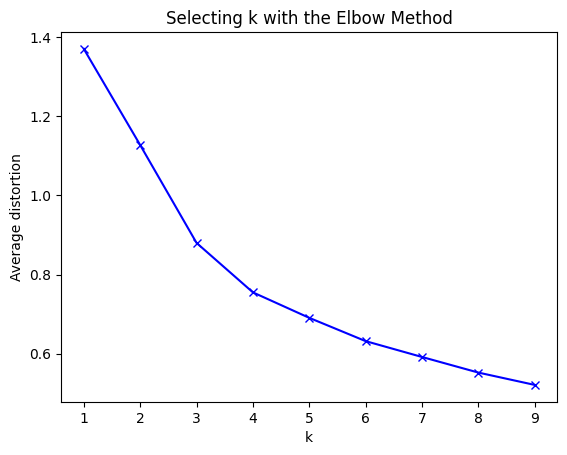

In [40]:
meanDistortions=[]

n_clusters = 10

for k in range(1, n_clusters):
    model=KMeans(n_clusters=k)
    model.fit(scaled_df)
    prediction=model.predict(scaled_df)
    meanDistortions.append(sum(np.min(cdist(scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / scaled_df.shape[0])

plt.plot(range(1, n_clusters), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [41]:
model = KMeans(n_clusters=3) # based on the elbow method
model.fit(scaled_df)
preds = model.predict(scaled_df)
labels = model.labels_
silhouette_score(scaled_df, labels, metric='euclidean')

0.4134925353081673

Number of clients in the cluster

In [42]:
scaled_df = pd.DataFrame(clientes_to_cluster, columns=clientes_to_cluster.columns)

# here we add the predictions to the unscaled data so that we can gain some real world interpretability
clientes_to_cluster['Kmean_grouping'] = preds 

scaled_df["Kmean_grouping"] = preds

clientes_to_cluster.groupby('Kmean_grouping').count()

,ingreso_promedio_300m,POBTOT_300m,gasto_promedio_300m
Kmean_grouping,,,
0,1128,1128,1128
1,160,160,160
2,707,707,707


Cluster stats

In [43]:
clientes_to_cluster.groupby('Kmean_grouping').mean()

,ingreso_promedio_300m,POBTOT_300m,gasto_promedio_300m
Kmean_grouping,,,
0,9353.678491,1245.113559,6255.623588
1,51170.472719,3922.128084,31770.467753
2,16152.013024,4435.970341,10755.829129


In [44]:
cluster_0 = clientes_to_cluster[clientes_to_cluster['Kmean_grouping'] == 0]
gasto_sobre_ingreso_0 = cluster_0['gasto_promedio_300m'].values[0] / cluster_0['ingreso_promedio_300m'].values[0]
cluster_1 = clientes_to_cluster[clientes_to_cluster['Kmean_grouping'] == 1]
gasto_sobre_ingreso_1 = cluster_1['gasto_promedio_300m'].values[0] / cluster_1['ingreso_promedio_300m'].values[0]
cluster_2 = clientes_to_cluster[clientes_to_cluster['Kmean_grouping'] == 2]
gasto_sobre_ingreso_2 = cluster_2['gasto_promedio_300m'].values[0] / cluster_2['ingreso_promedio_300m'].values[0]
# porcentaje de gasto sobre ingreso, para nosotros entre mayor sea este valor, mejor

print(f"Cluster 0: {round((gasto_sobre_ingreso_0 * 100), 1)}%")
print(f"Cluster 1: {round((gasto_sobre_ingreso_1 * 100), 1)}%")
print(f"Cluster 2: {round((gasto_sobre_ingreso_2 * 100), 1)}%")

Cluster 0: 69.7%
Cluster 1: 65.8%
Cluster 2: 67.8%


Clusters, analisis de poblacion al rededor de los clientes (300m):
- 1: Clase media, poblacion alta, gasto un poco bajo
- 2: Clase baja, poblacion baja, gasto bajo
- 2: Clase alta, poblacion media-alta, gasto alto

In [45]:
clientes_to_cluster

,ingreso_promedio_300m,POBTOT_300m,gasto_promedio_300m,Kmean_grouping
CustomerId,,,,
499920078,12654.604763,3449.000000,8576.205261,2
499920499,6275.434073,1419.632228,4374.288195,0
499921473,18157.022134,4544.000000,12071.934483,2
499921557,9803.177414,1625.000000,6664.661994,0
499921908,2264.192062,1656.644956,1648.526092,0
...,...,...,...,...
510844840,17926.440276,1189.600000,11699.409493,0
510845212,7836.264735,79.332169,5319.074049,0
510845646,46776.120447,3801.000000,30638.851531,1


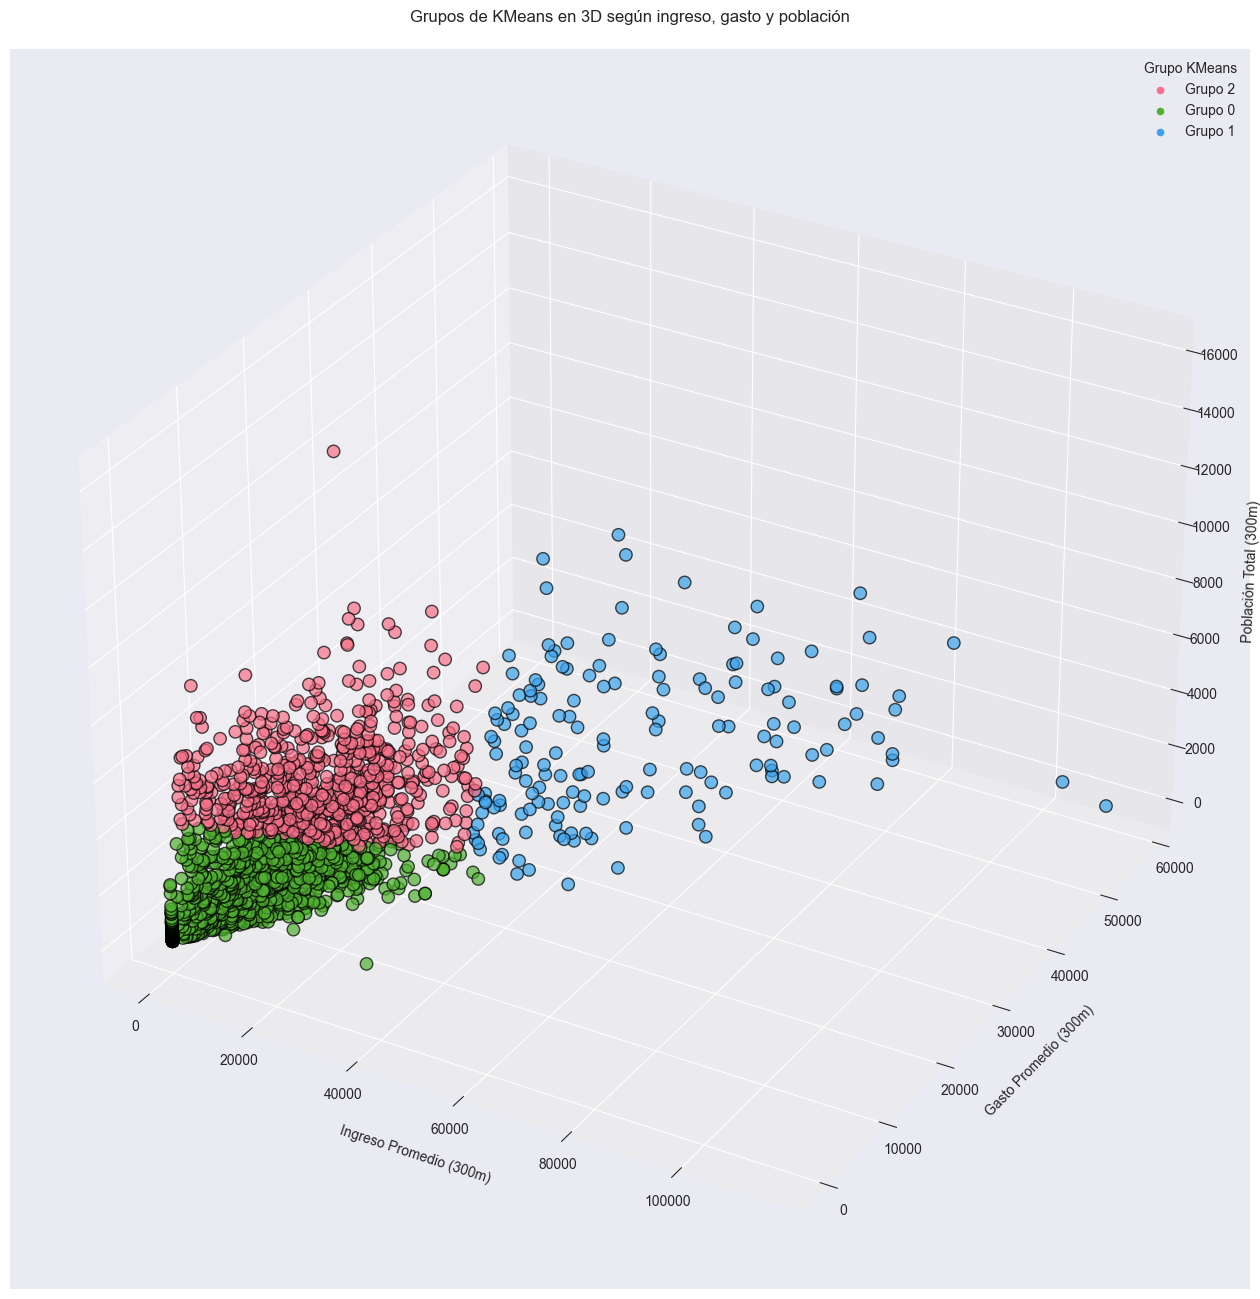

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd

# Configuración de estilo
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(16, 22))
ax = fig.add_subplot(111, projection='3d')

# Definir los colores del grupo
unique_groups = clientes_to_cluster['Kmean_grouping'].unique()
colors = sns.color_palette("husl", n_colors=len(unique_groups))

# Crear un diccionario para asignar colores a cada grupo
color_dict = {group: colors[i] for i, group in enumerate(unique_groups)}

# Asignar colores a cada punto basado en su grupo
group_colors = clientes_to_cluster['Kmean_grouping'].map(color_dict)

# Gráfico de dispersión en 3D
sc = ax.scatter(
    clientes_to_cluster['ingreso_promedio_300m'],
    clientes_to_cluster['gasto_promedio_300m'],
    clientes_to_cluster['POBTOT_300m'],
    c=group_colors,
    s=80,  # Tamaño de los puntos
    edgecolor='k',  # Borde de los puntos
    alpha=0.7  # Transparencia para mejorar la visualización
)

# Etiquetas y título
ax.set_title("Grupos de KMeans en 3D según ingreso, gasto y población", pad=20)
ax.set_xlabel("Ingreso Promedio (300m)", labelpad=10)
ax.set_ylabel("Gasto Promedio (300m)", labelpad=10)
ax.set_zlabel("Población Total (300m)", labelpad=10)

# Añadir leyenda
for group in unique_groups:
    ax.scatter([], [], [], color=color_dict[group], label=f'Grupo {group}')
ax.legend(title="Grupo KMeans", loc="best")

# Mostrar gráfico
plt.show()

Por ahora solo estamos interesados en el grupo 2

In [47]:
final_df = pd.merge(clientes_to_cluster, ventas_productos, on='CustomerId')
final_df = final_df.groupby(["CustomerId", "ProductType", "Kmean_grouping"]).agg({"Indicator": "mean"})

In [48]:
final_df

Indicator
CustomerId ProductType          Kmean_grouping           
499920078  AGUA MINERAL         2               -0.000060
           AGUA PURIFICADA      2               -0.000111
           AGUA SABORIZADA      2               -0.000004
           BEBIDA ALCOHOLICA    2               -0.000348
           BEBIDAS DE SOYA      2               -0.000004
...                                                   ...
500279118  LECHE UHT REGULAR    0               -0.003120
           LECHE UHT SABORIZADA 0               -0.000476
           NARANJADAS           0               -0.005017
           SABORES REGULAR      0               -0.006915
           TE                   0               -0.000175

[12315 rows x 1 columns]

In [49]:
def get_top_costumers(df, product_type, group, n_top):
    
    # Filter the DataFrame by ProductType and Kmean_grouping
    filtered_df = df.loc[(slice(None), product_type, group), :]
    
    # Sort by 'Indicator' in descending order to get the highest values
    sorted_df = filtered_df.sort_values(by='Indicator', ascending=False)
    
    # Get the top 10 ClientIds
    top_customers = sorted_df.head(n_top).reset_index()
    
    return top_customers

Make a test with a random product type

In [50]:
random_product_type = ventas_productos["ProductType"].sample().values[0]
print(f"Random Product Type: {random_product_type}")

get_top_costumers(final_df, random_product_type, 2, 10) # we are interest in the group 2

Random Product Type: COLAS REGULAR


,CustomerId,ProductType,Kmean_grouping,Indicator
0,499977249,COLAS REGULAR,2,0.001046
1,499923595,COLAS REGULAR,2,0.000112
2,500131939,COLAS REGULAR,2,0.000071
3,499924161,COLAS REGULAR,2,0.000010
4,500065978,COLAS REGULAR,2,0.000005
5,500045455,COLAS REGULAR,2,-0.000010
6,499986629,COLAS REGULAR,2,-0.000034
7,500190499,COLAS REGULAR,2,-0.000042
8,499920078,COLAS REGULAR,2,-0.000044
9,500113779,COLAS REGULAR,2,-0.000057


Top mas vendido

In [51]:
ventas_productos[ventas_productos["ProductType"] == random_product_type].groupby("CustomerId").agg({"uni_box": "sum"}).sort_values(by="uni_box", ascending=False).head(10)

,uni_box
CustomerId,
500070119,757568.016575
500276010,353689.183989
500184158,127207.183920
500062485,125387.900707
500086007,88085.818206
499927111,73826.284903
500144250,43477.729520
500172038,39738.458265
500147703,38192.677141


Como se puede ver, los tops son diferentes. Nuestra forma de hacerlo se enfoca en darle mas peso a aquellos clientes que estan teniendo ventas crecientes y tienen una cantidad de compras significativas del producto en cuestion. Aparte de enfocarnos en las zonas donde hay personas con mas dinero y que gastan mas (en cantidad).

<AxesSubplot: >

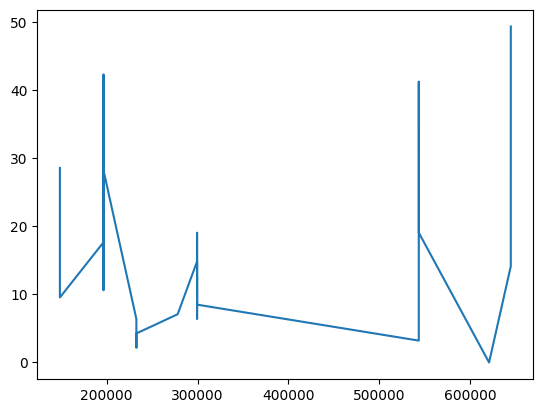

In [52]:
ventas_productos[(ventas_productos["ProductType"] == random_product_type) & (ventas_productos["CustomerId"] == 499977249)]["uni_box"].plot()